In [1]:
import os
import math
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch_geometric.data import Data as GeoData
from torch_geometric.nn import GCNConv
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Try Captum for IG; fallback to grad*input
try:
    from captum.attr import IntegratedGradients
    HAS_CAPTUM = True
except Exception:
    HAS_CAPTUM = False

# -------------------------
# CONFIG
# -------------------------
TRAIN_DATA_PATH = "slm_train_dataset.csv"
TEST_DATA_PATH  = "slm_test_dataset.csv"
BATCH_SIZE = 64
THRESHOLD = 0.05   # 30% of sequences must be predicted malicious
EPOCHS = 10
LEARNING_RATE = 1e-3
SEQ_LENGTH = 20  # Increased from 10
ANOMALY_WEIGHT_ALPHA = 1.5  # Reduced from 2
GNN_NODE_FEAT_DIM = 32
GNN_OUT_DIM = 64
LSTM_HIDDEN = 64
ATTN_DIM = 64
PIN_MEMORY = True
SEQUENCE_LABELING_STRATEGY = "threshold"   # "last", "threshold", or "weighted"
NUM_WORKERS = min(8, max(1, (os.cpu_count() or 4) // 2))
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
PRINT_PROGRESS = True
SAVE_MODEL_PATH = "slm_enhanced_model.pth"

print(f"Device: {DEVICE} | Num workers: {NUM_WORKERS} | Pin memory: {PIN_MEMORY}")

# -------------------------
# UTILS: reproducibility
# -------------------------
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True
    # higher precision for matmul on modern NVIDIA
    try:
        torch.set_float32_matmul_precision('high')
    except Exception:
        pass
    try:
        torch.backends.cuda.matmul.allow_tf32 = True
    except Exception:
        pass

# -------------------------
# 1) LOAD DUAL DATASETS
# -------------------------
if not os.path.exists(TRAIN_DATA_PATH):
    raise FileNotFoundError(f"Train dataset not found at: {TRAIN_DATA_PATH}")
if not os.path.exists(TEST_DATA_PATH):
    raise FileNotFoundError(f"Test dataset not found at: {TEST_DATA_PATH}")

print("📥 Loading datasets...")
df_train = pd.read_csv(TRAIN_DATA_PATH)
df_test  = pd.read_csv(TEST_DATA_PATH)
print(f"Loaded train: {df_train.shape} | test: {df_test.shape}")

# -------------------------
# 2) PREPROCESS (fit on train, apply to test)
# -------------------------
def basic_time_features(df):
    df = df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
    df['hour'] = df['timestamp'].dt.hour.fillna(0).astype(int)
    df['day_of_week'] = df['timestamp'].dt.dayofweek.fillna(0).astype(int)
    df['day'] = df['timestamp'].dt.day.fillna(0).astype(int)
    df['is_weekend'] = df['day_of_week'].isin([5,6]).astype(int)
    df['is_night'] = ((df['hour'] < 6) | (df['hour'] > 22)).astype(int)
    df = df.fillna(0)
    return df

print("🔧 Applying basic time feature extraction...")
df_train = basic_time_features(df_train)
df_test  = basic_time_features(df_test)

# categorical columns (update to match your CSV)
cat_cols = [
    'host_id', 'host_hostname', 'host_id_unique', 'user_id',
    'src_ip', 'dst_ip', 'dst_host', 'event_type', 'process_name',
    'parent_process', 'command_line_args', 'auth_result', 'auth_type',
    'logon_type', 'protocol', 'zone_src', 'zone_dst', 'attack_stage', 'session_id'
]

# Fit LabelEncoders on training data and apply to test
encoders = {}
for col in cat_cols:
    if col in df_train.columns:
        le = LabelEncoder()
        # fit on combined train values to be robust (train primary, but include unseen in test)
        le.fit(df_train[col].astype(str).tolist() + df_test.get(col, pd.Series(dtype=str)).astype(str).tolist())
        df_train[col] = le.transform(df_train[col].astype(str))
        if col in df_test.columns:
            # transform test; unseen values are handled because we fit on combined above
            df_test[col] = le.transform(df_test[col].astype(str))
        encoders[col] = le

# Ensure label column exists
if 'is_stealth_lateral_movement' not in df_train.columns or 'is_stealth_lateral_movement' not in df_test.columns:
    raise ValueError("Both datasets must contain 'is_stealth_lateral_movement' column")

# Split X/y
y_train = df_train['is_stealth_lateral_movement'].astype(int)
X_train = df_train.drop(columns=['is_stealth_lateral_movement'])
y_test = df_test['is_stealth_lateral_movement'].astype(int)
X_test = df_test.drop(columns=['is_stealth_lateral_movement'])

# Numeric scaling: fit StandardScaler on train and apply to test
num_cols = ['port','bytes_in','bytes_out','hour','day_of_week','day']
scaler = StandardScaler()
for col in num_cols:
    if col in X_train.columns:
        # Fit only on train
        X_train[col] = scaler.fit_transform(X_train[[col]])
        if col in X_test.columns:
            X_test[col] = scaler.transform(X_test[[col]])

print(f"✅ Preprocessing complete. Train shape: {X_train.shape} | Test shape: {X_test.shape}")
print(f"Train stealth count: {int(y_train.sum())} | Test stealth count: {int(y_test.sum())}")

# ==========================================================
# 3) SAFE ANOMALY DETECTION (auto-encode leftover strings)
# ==========================================================
print('🚀 Running Isolation Forest anomaly detection...')

X_train_clean = X_train.drop(columns=['timestamp'], errors='ignore').copy()
X_test_clean  = X_test.drop(columns=['timestamp'], errors='ignore').copy()

# Detect any non-numeric columns and encode them (safe fallback)
non_numeric_cols = X_train_clean.select_dtypes(include=['object']).columns.tolist()
if non_numeric_cols:
    print(f"⚠️ Found non-numeric columns: {non_numeric_cols} — encoding now...")
    for col in non_numeric_cols:
        le = LabelEncoder()
        combined = list(X_train_clean[col].astype(str)) + list(X_test_clean.get(col, pd.Series(dtype=str)).astype(str))
        le.fit(combined)
        X_train_clean[col] = le.transform(X_train_clean[col].astype(str))
        if col in X_test_clean.columns:
            X_test_clean[col] = le.transform(X_test_clean[col].astype(str))
    print("✅ All columns converted to numeric.")

# Verify numeric-only data
assert all(pd.api.types.is_numeric_dtype(X_train_clean[col]) for col in X_train_clean.columns), \
    "Non-numeric data found even after encoding!"

# Run Isolation Forest on train-clean only
iso = IsolationForest(n_estimators=200, contamination=0.03, random_state=42, n_jobs=-1)
iso.fit(X_train_clean)
X_train['anomaly_score'] = -iso.decision_function(X_train_clean)
X_test['anomaly_score'] = -iso.decision_function(X_test_clean)
print("✅ Anomaly detection complete.")

# ==========================================================
# 4) GRAPH PREPARATION
# ==========================================================
def build_graph(X_part):
    edge_index = []
    # ensure host_id and user_id exist
    if 'host_id' not in X_part.columns or 'user_id' not in X_part.columns:
        # fallback: create minimal graph with one node
        node_features = torch.randn(1, GNN_NODE_FEAT_DIM, dtype=torch.float32)
        edge_index = torch.tensor([[0],[0]], dtype=torch.long)
        g = GeoData(x=node_features, edge_index=edge_index)
        g.host_map = {}
        g.user_map = {}
        g.hosts = []
        g.users = []
        return g

    hosts = np.unique(X_part['host_id'].astype(int))
    users = np.unique(X_part['user_id'].astype(int))
    host_map = {int(h): i for i, h in enumerate(hosts)}
    user_map = {int(u): len(hosts) + i for i, u in enumerate(users)}

    for _, row in X_part.iterrows():
        try:
            h_val = int(row['host_id'])
            u_val = int(row['user_id'])
        except Exception:
            continue
        if h_val not in host_map or u_val not in user_map:
            continue
        h = host_map[h_val]
        u = user_map[u_val]
        edge_index.append([u, h]); edge_index.append([h, u])

    if len(edge_index) == 0:
        edge_index = [[0,0]]

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    n_nodes = len(hosts) + len(users)
    node_features = torch.randn(n_nodes, GNN_NODE_FEAT_DIM, dtype=torch.float32)
    g = GeoData(x=node_features, edge_index=edge_index)
    g.host_map = host_map; g.user_map = user_map; g.hosts = hosts; g.users = users
    return g

train_graph = build_graph(X_train)
test_graph = build_graph(X_test)
print(f"Train graph nodes: {train_graph.x.shape[0]}, Test graph nodes: {test_graph.x.shape[0]}")

Device: cuda | Num workers: 8 | Pin memory: True
📥 Loading datasets...
Loaded train: (179951, 26) | test: (179951, 26)
🔧 Applying basic time feature extraction...
✅ Preprocessing complete. Train shape: (179951, 30) | Test shape: (179951, 30)
Train stealth count: 1343 | Test stealth count: 1343
🚀 Running Isolation Forest anomaly detection...
⚠️ Found non-numeric columns: ['privilege_level'] — encoding now...
✅ All columns converted to numeric.
✅ Anomaly detection complete.
Train graph nodes: 314, Test graph nodes: 314


In [2]:
# ==========================================================
# 5) SAFE SEQUENCE CREATION (robust host-level builder)
# ==========================================================
def create_sequences(X_data, y_data, seq_length=SEQ_LENGTH, graph=None):
    """Build overlapping sequences per host with anomaly mean tracking."""
    if 'host_id' not in X_data.columns:
        raise KeyError("Column 'host_id' not found in X_data — check preprocessing.")

    X_data_clean = X_data.drop(columns=['timestamp'], errors='ignore').copy()
    # Ensure numeric conversion for safety
    for col in X_data_clean.columns:
        if X_data_clean[col].dtype == 'object':
            X_data_clean[col] = pd.factorize(X_data_clean[col])[0]

    if 'anomaly_score' not in X_data_clean.columns:
        X_data_clean['anomaly_score'] = 0.0

    X_data_clean = X_data_clean.replace([np.inf, -np.inf], np.nan).fillna(0)

    sequences, labels, host_node_idxs, seq_anom_means = [], [], [], []
    host_map = getattr(graph, 'host_map', None) if graph is not None else {}

    unique_hosts = X_data_clean['host_id'].unique()
    if len(unique_hosts) == 0:
        raise ValueError("No hosts found in data (check host_id column).")

    for host_id in unique_hosts:
        host_mask = X_data_clean['host_id'] == host_id
        host_df = X_data_clean.loc[host_mask]
        if host_df.empty:
            continue

        host_arr = host_df.values
        host_labels = y_data.loc[host_mask].values if isinstance(y_data, pd.Series) else y_data[host_mask].values
        host_anom = host_df['anomaly_score'].values  # ✅ fixed line

        if np.isnan(host_anom).any():
            host_anom = np.nan_to_num(host_anom, nan=0.0)

        # fallback for small hosts
        if len(host_arr) < seq_length:
            for i in range(len(host_arr)):
                sequences.append(host_arr[i:i+1])
                labels.append(int(host_labels[i]))
                idx = host_map.get(int(host_id), 0)
                host_node_idxs.append(idx)
                seq_anom_means.append(float(np.mean(host_anom[max(i, 0):i+1])))
            continue

        # sliding window
        # sliding window
        for i in range(len(host_arr) - seq_length + 1):
            seq = host_arr[i:i+seq_length]
            sequences.append(seq)

            window_labels = host_labels[i:i+seq_length]
            window_anoms  = host_anom[i:i+seq_length]

            # ---- CHOOSE LABELING METHOD ----
            if SEQUENCE_LABELING_STRATEGY == "last":
                # Option A
                label = int(window_labels[-1])

            elif SEQUENCE_LABELING_STRATEGY == "threshold":
                # Option B
                label = 1 if np.sum(window_labels) >= 2 else 0

            elif SEQUENCE_LABELING_STRATEGY == "weighted":
                # Option C
                mal_score = np.sum(window_labels * (1 + window_anoms))
                label = 1 if mal_score > 1.5 else 0

            else:
                # default fallback to old method (not recommended)
                label = int(np.max(window_labels))

            labels.append(label)

            # other fields remain same
            idx = host_map.get(int(host_id), 0)
            host_node_idxs.append(idx)
            seq_anom_means.append(float(np.mean(window_anoms)))


    if len(sequences) == 0:
        raise ValueError("No sequences created — check data content and host_id mapping.")

    # Pad sequences for equal length (should already be seq_length)
    max_len = max(len(s) for s in sequences)
    feat_dim = sequences[0].shape[1]
    padded = []
    for s in sequences:
        if len(s) < max_len:
            pad = np.zeros((max_len - len(s), feat_dim))
            s = np.vstack([s, pad])
        padded.append(s)

    sequences = np.array(padded, dtype=np.float32)
    labels = np.array(labels, dtype=np.int64)
    host_node_idxs = np.array(host_node_idxs, dtype=np.int64)
    seq_anom_means = np.array(seq_anom_means, dtype=np.float32)

    print(f"✅ Sequences built: {len(sequences)} | Features: {feat_dim} | Seq len: {max_len}")
    return (
        torch.tensor(sequences, dtype=torch.float32),
        torch.tensor(labels, dtype=torch.long),
        torch.tensor(host_node_idxs, dtype=torch.long),
        torch.tensor(seq_anom_means, dtype=torch.float32),
    )

print("🔄 Creating sequences...")
X_train_seq, y_train_seq, train_host_node_idxs, train_seq_anom_mean = create_sequences(
    X_train, y_train, seq_length=SEQ_LENGTH, graph=train_graph
)
X_test_seq, y_test_seq, test_host_node_idxs, test_seq_anom_mean = create_sequences(
    X_test, y_test, seq_length=SEQ_LENGTH, graph=test_graph
)

print(f"Train seqs: {X_train_seq.shape}, Test seqs: {X_test_seq.shape}")

train_dataset = TensorDataset(X_train_seq, y_train_seq, train_host_node_idxs, train_seq_anom_mean)
test_dataset  = TensorDataset(X_test_seq,  y_test_seq,  test_host_node_idxs,  test_seq_anom_mean)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    drop_last=True,
)
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
)

🔄 Creating sequences...
✅ Sequences built: 178051 | Features: 30 | Seq len: 20
✅ Sequences built: 178051 | Features: 30 | Seq len: 20
Train seqs: torch.Size([178051, 20, 30]), Test seqs: torch.Size([178051, 20, 30])


In [3]:
# -------------------------
# 6) Model components
# -------------------------
class GNNEncoder(nn.Module):
    def __init__(self, in_feats=GNN_NODE_FEAT_DIM, hidden=64, out_feats=GNN_OUT_DIM):
        super().__init__()
        self.conv1 = GCNConv(in_feats, hidden)
        self.conv2 = GCNConv(hidden, out_feats)
    def forward(self, x, edge_index):
        x = torch.relu(self.conv1(x, edge_index))
        x = torch.relu(self.conv2(x, edge_index))
        return x

class SelfAttention(nn.Module):
    def __init__(self, hidden_dim, attn_dim=ATTN_DIM):
        super().__init__()
        self.proj = nn.Sequential(nn.Linear(hidden_dim, attn_dim), nn.Tanh(), nn.Linear(attn_dim, 1))
    def forward(self, lstm_out):
        weights = self.proj(lstm_out)  # (b, seq, 1)
        weights = torch.softmax(weights, dim=1)
        weighted = (lstm_out * weights).sum(dim=1)
        return weighted, weights.squeeze(-1)

class BiLSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes=2, bidirectional=True):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.bidirectional = bidirectional
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, batch_first=True, bidirectional=bidirectional)
        factor = 2 if bidirectional else 1
        self.attn = SelfAttention(hidden_dim * factor, attn_dim=ATTN_DIM)
        self.fc = nn.Linear(hidden_dim * factor, num_classes)
    def forward(self, x):
        out, _ = self.lstm(x)
        weighted, attn_weights = self.attn(out)
        logits = self.fc(weighted)
        return logits, attn_weights, out

class StealthLateralModel(nn.Module):
    def __init__(self, input_dim, gnn_out_dim=GNN_OUT_DIM, lstm_hidden=LSTM_HIDDEN):
        super().__init__()
        self.gnn = GNNEncoder(in_feats=GNN_NODE_FEAT_DIM, out_feats=gnn_out_dim)
        self.lstm = BiLSTMModel(input_dim + gnn_out_dim, hidden_dim=lstm_hidden, num_classes=2)
    def forward(self, graph_data, seq_batch, host_node_idxs, seq_anom_means):
        # compute gnn embeddings
        gnn_out = self.gnn(graph_data.x, graph_data.edge_index)  # (n_nodes, gnn_out_dim)
        # gather host node embeddings
        node_embeds = gnn_out[host_node_idxs]  # (batch, gnn_out_dim)
        batch_size, seq_len, _ = seq_batch.shape
        node_embeds_expanded = node_embeds.unsqueeze(1).repeat(1, seq_len, 1)
        # normalize and weight anomaly
        if seq_anom_means.numel() > 1:
            norm = (seq_anom_means - seq_anom_means.min()) / (seq_anom_means.max() - seq_anom_means.min() + 1e-6)
        else:
            norm = seq_anom_means * 0.0
        weights = (1.0 + ANOMALY_WEIGHT_ALPHA * norm).unsqueeze(-1).unsqueeze(-1)
        node_embeds_expanded = node_embeds_expanded * weights.to(node_embeds_expanded.device)
        seq_with_context = torch.cat([seq_batch, node_embeds_expanded.to(seq_batch.dtype)], dim=-1)
        logits, attn_weights, lstm_outs = self.lstm(seq_with_context)
        return logits, attn_weights, lstm_outs, gnn_out

# instantiate model
input_dim = X_train_seq.shape[-1]
model = StealthLateralModel(input_dim=input_dim, gnn_out_dim=GNN_OUT_DIM, lstm_hidden=LSTM_HIDDEN).to(DEVICE)
print("Model created.")

# class weights for imbalance (on sequence-level)
counts = np.bincount(y_train_seq.numpy())
if len(counts) == 1:
    class_weights = torch.tensor([1.0,1.0], dtype=torch.float32).to(DEVICE)
else:
    pos_weight = (counts.sum() / (2.0 * counts[1])) if counts[1] > 0 else 1.0
    class_weights = torch.tensor([1.0, pos_weight], dtype=torch.float32).to(DEVICE)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# multi-GPU guard (your 4050 is single GPU; this is safe)
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)
    print("DataParallel mode enabled.")

Model created.


In [4]:
# -------------------------
# 7) Training (AMP, cached GNN embeddings)
# -------------------------
scaler = torch.cuda.amp.GradScaler()
print("Begin training...")

def compute_gnn_embeddings_once(model_obj, graph_data):
    """
    Compute and return GNN embeddings while preserving the model's original
    training/eval state so we don't accidentally leave RNNs in eval mode.
    """
    was_training = model_obj.training  # save original state
    try:
        model_obj.eval()
        with torch.no_grad(), torch.cuda.amp.autocast():
            if isinstance(model_obj, nn.DataParallel):
                g_emb = model_obj.module.gnn(graph_data.x, graph_data.edge_index)
            else:
                g_emb = model_obj.gnn(graph_data.x, graph_data.edge_index)
    finally:
        # restore original mode
        if was_training:
            model_obj.train()
        else:
            model_obj.eval()
    return g_emb  # (n_nodes, gnn_out_dim)

# prepare graphs on device
train_graph_data = GeoData(x=train_graph.x.to(DEVICE), edge_index=train_graph.edge_index.to(DEVICE))
test_graph_data  = GeoData(x=test_graph.x.to(DEVICE),  edge_index=test_graph.edge_index.to(DEVICE))

# helper to forward using cached gnn embeddings (so we don't run gnn conv every batch)
def forward_with_cached_lstm(model_obj, cached_gnn_embeds, seq_batch, host_idx, seq_anom):
    # cached_gnn_embeds: (n_nodes, gnn_out_dim)
    node_embeds = cached_gnn_embeds[host_idx]  # gather
    seq_len = seq_batch.shape[1]
    node_expanded = node_embeds.unsqueeze(1).repeat(1, seq_len, 1)
    if seq_anom.numel() > 1:
        norm = (seq_anom - seq_anom.min()) / (seq_anom.max() - seq_anom.min() + 1e-6)
    else:
        norm = seq_anom * 0.0
    weights = (1.0 + ANOMALY_WEIGHT_ALPHA * norm).unsqueeze(-1).unsqueeze(-1)
    node_expanded = node_expanded * weights.to(node_expanded.device)
    seq_context = torch.cat([seq_batch, node_expanded.to(seq_batch.dtype)], dim=-1)
    # pass through only LSTM component
    if isinstance(model_obj, nn.DataParallel):
        logits, attn_w, lstm_outs = model_obj.module.lstm(seq_context)
    else:
        logits, attn_w, lstm_outs = model_obj.lstm(seq_context)
    return logits, attn_w, lstm_outs

for epoch in range(EPOCHS):
    model.train()                 # ensure training mode at epoch start
    total_loss = 0.0

    # compute cached gnn embeddings (this function now restores model state)
    cached_train_gnn = compute_gnn_embeddings_once(model, train_graph_data)

    for batch_idx, (batch_x, batch_y, batch_host_idx, batch_seq_anom) in enumerate(train_loader):
        # move to device etc.
        batch_x = batch_x.to(DEVICE, non_blocking=True).float()
        batch_y = batch_y.to(DEVICE, non_blocking=True).long()
        batch_host_idx = batch_host_idx.to(DEVICE, non_blocking=True).long()
        batch_seq_anom = batch_seq_anom.to(DEVICE, non_blocking=True).float()

        optimizer.zero_grad(set_to_none=True)

        with torch.cuda.amp.autocast():
            logits, _, _ = forward_with_cached_lstm(model, cached_train_gnn, batch_x, batch_host_idx, batch_seq_anom)
            loss = criterion(logits, batch_y)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item()

        if PRINT_PROGRESS and (batch_idx + 1) % 50 == 0:
            print(f"Epoch {epoch+1}/{EPOCHS} | Step {batch_idx+1}/{len(train_loader)} | Loss {loss.item():.4f}")

    avg_loss = total_loss / max(1, len(train_loader))
    print(f"Epoch {epoch+1}/{EPOCHS} completed. Avg Loss: {avg_loss:.4f}")

print("Training finished.")
torch.cuda.empty_cache()

Begin training...
Epoch 1/10 | Step 50/2782 | Loss 0.7630
Epoch 1/10 | Step 100/2782 | Loss 0.6286
Epoch 1/10 | Step 150/2782 | Loss 0.7190
Epoch 1/10 | Step 200/2782 | Loss 0.8499
Epoch 1/10 | Step 250/2782 | Loss 0.3430
Epoch 1/10 | Step 300/2782 | Loss 0.4632
Epoch 1/10 | Step 350/2782 | Loss 0.5977
Epoch 1/10 | Step 400/2782 | Loss 0.5705
Epoch 1/10 | Step 450/2782 | Loss 0.4409
Epoch 1/10 | Step 500/2782 | Loss 0.5561
Epoch 1/10 | Step 550/2782 | Loss 0.4494
Epoch 1/10 | Step 600/2782 | Loss 0.6630
Epoch 1/10 | Step 650/2782 | Loss 0.6918
Epoch 1/10 | Step 700/2782 | Loss 0.4796
Epoch 1/10 | Step 750/2782 | Loss 0.4891
Epoch 1/10 | Step 800/2782 | Loss 0.3747
Epoch 1/10 | Step 850/2782 | Loss 0.5481
Epoch 1/10 | Step 900/2782 | Loss 0.4507
Epoch 1/10 | Step 950/2782 | Loss 0.5592
Epoch 1/10 | Step 1000/2782 | Loss 0.3889
Epoch 1/10 | Step 1050/2782 | Loss 0.4160
Epoch 1/10 | Step 1100/2782 | Loss 0.6131
Epoch 1/10 | Step 1150/2782 | Loss 0.5646
Epoch 1/10 | Step 1200/2782 | Loss 0


=== Overall Test Metrics ===
Accuracy: 0.9836
              precision    recall  f1-score   support

      Benign       0.99      0.99      0.99    172447
     Stealth       0.74      0.74      0.74      5604

    accuracy                           0.98    178051
   macro avg       0.87      0.86      0.87    178051
weighted avg       0.98      0.98      0.98    178051



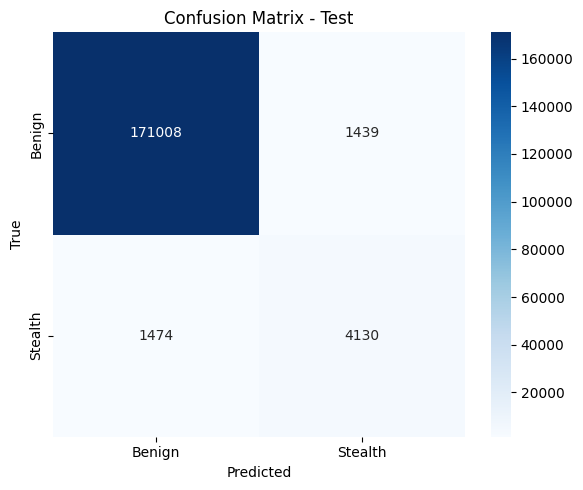


Per-host summary (head):
   host_node_idx  n_sequences  true_compromised  pred_compromised  \
0              0         1253                 1                 1   
1              1         2210                 0                 0   
2              2         2016                 0                 0   
3              3         2451                 0                 0   
4              4         1301                 0                 0   
5              5         1144                 0                 0   
6              6         1672                 0                 0   
7              7         2780                 1                 0   
8              8         1263                 1                 1   
9              9         1377                 0                 0   

   detection_rate_for_host  
0                 0.056664  
1                 0.000452  
2                 0.000496  
3                 0.000408  
4                 0.000000  
5                 0.000000  
6          

In [5]:
# -------------------------
# 8) Evaluation (test)
# -------------------------
model.eval()
all_preds, all_true, all_hosts = [], [], []

with torch.no_grad(), torch.cuda.amp.autocast():
    cached_test_gnn = compute_gnn_embeddings_once(model, test_graph_data)
    for batch_x, batch_y, batch_host_idx, batch_seq_anom in test_loader:
        batch_x = batch_x.to(DEVICE, non_blocking=True).float()
        batch_y = batch_y.to(DEVICE, non_blocking=True).long()
        batch_host_idx = batch_host_idx.to(DEVICE, non_blocking=True).long()
        batch_seq_anom = batch_seq_anom.to(DEVICE, non_blocking=True).float()

        logits, attn_w, _ = forward_with_cached_lstm(model, cached_test_gnn, batch_x, batch_host_idx, batch_seq_anom)
        preds = torch.argmax(logits, dim=1).detach().cpu().numpy()
        all_preds.extend(preds.tolist())
        all_true.extend(batch_y.cpu().numpy().tolist())
        all_hosts.extend(batch_host_idx.cpu().numpy().tolist())

all_preds = np.array(all_preds); all_true = np.array(all_true); all_hosts = np.array(all_hosts)
acc = accuracy_score(all_true, all_preds)
print("\n=== Overall Test Metrics ===")
print(f"Accuracy: {acc:.4f}")
print(classification_report(all_true, all_preds, target_names=["Benign", "Stealth"], zero_division=0))

cm = confusion_matrix(all_true, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Benign","Stealth"], yticklabels=["Benign","Stealth"])
plt.title("Confusion Matrix - Test")
plt.xlabel("Predicted"); plt.ylabel("True"); plt.tight_layout(); plt.show()

# Per-host evaluation
per_host_stats = []
unique_hosts = np.unique(all_hosts)
for h in unique_hosts:
    idxs = np.where(all_hosts == h)[0]
    # True label for host: same rule (any stealth sequence → stealth host)
    t = int(all_true[idxs].max() > 0)
    # Prediction for host using threshold
    seq_pred = all_preds[idxs]
    detection_rate = np.mean(seq_pred)   # % of sequences predicted as stealth
    p = int(detection_rate >= THRESHOLD) # threshold decision
    per_host_stats.append({
        'host_node_idx': int(h),
        'n_sequences': len(idxs),
        'true_compromised': t,
        'pred_compromised': p,
        'detection_rate_for_host': float(detection_rate),
    })


per_host_df = pd.DataFrame(per_host_stats)
print("\nPer-host summary (head):")
print(per_host_df.head(10))
tp = ((per_host_df['true_compromised']==1) & (per_host_df['pred_compromised']==1)).sum()
fn = ((per_host_df['true_compromised']==1) & (per_host_df['pred_compromised']==0)).sum()
fp = ((per_host_df['true_compromised']==0) & (per_host_df['pred_compromised']==1)).sum()
tn = ((per_host_df['true_compromised']==0) & (per_host_df['pred_compromised']==0)).sum()
print(f"\nPer-host counts: TP={tp}, FN={fn}, FP={fp}, TN={tn}")

# Save model weights (best-practice: track val metric and save best; here we save final)
try:
    model_to_save = model.module.state_dict() if isinstance(model, nn.DataParallel) else model.state_dict()
    torch.save(model_to_save, SAVE_MODEL_PATH)
    print(f"Model saved to {SAVE_MODEL_PATH}")
except Exception as e:
    print("Model save failed:", e)

In [6]:
# -------------------------
# 9) Explainability helper: Integrated Gradients (Captum) or gradient*input fallback
# -------------------------
def compute_sequence_attribution(
        model_obj,
        graph_data,
        seq_tensor,
        host_node_idx_tensor,
        seq_anom_tensor,
        target_label=1,
        steps=50
    ):
    """
    seq_tensor: Tensor [1, seq_len, feat_dim]
    host_node_idx_tensor: Tensor [1]
    seq_anom_tensor: Tensor [1] or [1, 1] → expanded to [1, seq_len, 1]
    returns dict with 'seq_attr' (1, seq_len, feat_dim) and metadata
    """

    model_obj.eval()

    # ----------- Prepare tensors -----------
    seq_tensor = seq_tensor.to(DEVICE).float().requires_grad_(True)
    host_node_idx_tensor = host_node_idx_tensor.to(DEVICE).long()
    seq_anom_tensor = seq_anom_tensor.to(DEVICE).float()

    # 🔥 FIX: Expand anomaly scalar to match sequence length
    # seq_anom_tensor comes as shape [1] or [1,1]
    if seq_anom_tensor.dim() == 1:
        # [1] → [1,1]
        seq_anom_tensor = seq_anom_tensor.unsqueeze(1)

    seq_len = seq_tensor.shape[1]  # number of timesteps
    # [1,1] → [1,seq_len] → [1,seq_len,1]
    seq_anom_tensor = seq_anom_tensor.repeat(1, seq_len).unsqueeze(-1)

    # Now safe to pass to model
    # ----------------------------------------

    # Prepare graph data
    graph_data = GeoData(
        x=graph_data.x.to(DEVICE),
        edge_index=graph_data.edge_index.to(DEVICE)
    )

    # Compute cached GNN embeddings once
    cached_gnn = compute_gnn_embeddings_once(model_obj, graph_data)

    # ----------- Forward wrapper for IG -----------
    def forward_scalar(input_seq):
        logits, _, _ = forward_with_cached_lstm(
            model_obj,
            cached_gnn,
            input_seq,
            host_node_idx_tensor,
            seq_anom_tensor
        )
        return logits[:, target_label]

    # ----------- Integrated Gradients or fallback -----------
    if HAS_CAPTUM:
        ig = IntegratedGradients(forward_scalar)
        attributions, delta = ig.attribute(
            seq_tensor,
            n_steps=steps,
            return_convergence_delta=True
        )
        return {
            "seq_attr": attributions.detach().cpu().numpy(),
            "delta": delta
        }

    else:
        # fallback: grad * input
        logits, _, _ = forward_with_cached_lstm(
            model_obj,
            cached_gnn,
            seq_tensor,
            host_node_idx_tensor,
            seq_anom_tensor
        )
        prob = logits[:, target_label].sum()
        prob.backward()

        grads = seq_tensor.grad
        attr = (grads * seq_tensor).detach().cpu().numpy()

        return {"seq_attr": attr, "note": "grad*input fallback"}


# -------------------------
# Example usage on first test sample
# -------------------------
try:
    if X_test_seq.shape[0] > 0:
        sample_seq = X_test_seq[0:1]              # [1, seq_len, feat_dim]
        sample_host_idx = test_host_node_idxs[0:1]  # [1]
        sample_seq_anom = test_seq_anom_mean[0:1]   # [1] → will be expanded inside function

        explain_res = compute_sequence_attribution(
            model,
            test_graph,
            sample_seq,
            sample_host_idx,
            sample_seq_anom
        )

        print("Explainability seq attr shape:", explain_res.get("seq_attr").shape)

except Exception as e:
    print("Explainability sample failed:", e)

print("\nPipeline done.")


Explainability sample failed: Tensors must have same number of dimensions: got 3 and 5

Pipeline done.


In [7]:
"""
slm_train_and_save.py
Trains the full Stealth Lateral Movement detection model and saves all artifacts for inference.
"""

import os, joblib, torch

# ==========================================================
# After training finishes (assume 'model', 'iso', 'scaler', 'encoders', 'train_graph_data' exist)
# ==========================================================
SAVE_DIR = "saved_models"
os.makedirs(SAVE_DIR, exist_ok=True)

MODEL_PATH = os.path.join(SAVE_DIR, "slm_enhanced_model.pth")
ENCODERS_PATH = os.path.join(SAVE_DIR, "label_encoders.pkl")
SCALER_PATH = os.path.join(SAVE_DIR, "scaler.pkl")
GNN_CACHE_PATH = os.path.join(SAVE_DIR, "cached_train_gnn.pt")
ANOMALY_MODEL_PATH = os.path.join(SAVE_DIR, "isolation_forest.pkl")

try:
    # Save unified neural model (GNN + BiLSTM + Attention)
    model_to_save = model.module.state_dict() if isinstance(model, torch.nn.DataParallel) else model.state_dict()
    torch.save(model_to_save, MODEL_PATH)

    # Save all preprocessing + anomaly model
    joblib.dump(encoders, ENCODERS_PATH)
    joblib.dump(scaler, SCALER_PATH)
    joblib.dump(iso, ANOMALY_MODEL_PATH)

    # Save cached GNN embeddings (optional, speeds up inference)
    cached_gnn = compute_gnn_embeddings_once(model, train_graph_data)
    torch.save(cached_gnn, GNN_CACHE_PATH)

    print(f"✅ All components saved to: {SAVE_DIR}/")
except Exception as e:
    print("❌ Model save failed:", e)


✅ All components saved to: saved_models/
